# Part 1

In [71]:
import sqlite3
import pandas
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


## Problem 1
Using Using SQL compute a relation containing the total payroll and winning percentage (number of wins / number of games * 100) for each team (that is, for each teamID and yearID combination).

I dealt with the missing salaries from before 1990 by joining the two tables, team salaries and team win percentages, starting at 1990. 

In [72]:
# Connecting to sql database
sqlite_file = 'lahman2014 (2).sqlite'
conn = sqlite3.connect(sqlite_file)

# Query from the Salaries table to get total salary for each team per year
salary_query = """SELECT yearID, teamID, sum(salary) as total_payroll 
                FROM Salaries
                GROUP BY yearID, teamID"""

# Create dataframe from query
team_salaries = pandas.read_sql(salary_query, conn)

# Query from the Teams table to get win percentage for each team per year from 1990
win_percentage_query = """ Select yearID, teamID, W, G, franchID, 
                          (cast (W as float)/cast(G as float))*100.0 as win_percentage
                          FROM Teams
                          WHERE yearID >= 1990
                          GROUP BY yearID, teamID 
"""

# Create dataframe from query
team_win_percentages = pandas.read_sql(win_percentage_query, conn)


# Converting tables to sql to join the two together on years and teams
team_win_percentages = team_win_percentages.to_sql('team_win_percentages', conn, if_exists='replace')
team_salaries = team_salaries.to_sql('team_salaries', conn, if_exists='replace')

relation_query = """ 
                  select team_salaries.yearID, team_win_percentages.teamID, 
                        team_win_percentages.franchID, team_win_percentages.W, 
                        team_win_percentages.G, team_salaries.total_payroll,
                        team_win_percentages.win_percentage
                  from team_salaries
                  join team_win_percentages
                  on team_win_percentages.yearID = team_salaries.yearID and 
                  team_salaries.teamID = team_win_percentages.teamID
"""

df = pandas.read_sql(relation_query, conn)
df

,yearID,teamID,franchID,W,G,total_payroll,win_percentage
0,1990,ATL,ATL,65,162,14555501.0,40.123457
1,1990,BAL,BAL,76,161,9680084.0,47.204969
2,1990,BOS,BOS,88,162,20558333.0,54.320988
3,1990,CAL,ANA,80,162,21720000.0,49.382716
4,1990,CHA,CHW,94,162,9491500.0,58.024691
...,...,...,...,...,...,...,...
723,2014,SLN,STL,90,162,120693000.0,55.555556
724,2014,TBA,TBD,77,162,72689100.0,47.530864
725,2014,TEX,TEX,67,162,112255059.0,41.358025
726,2014,TOR,TOR,83,162,109920100.0,51.234568


# Part 2

### Problem 2
Produce a plot that illustrates the distribution of payrolls across all teams from 1990 - 2014.

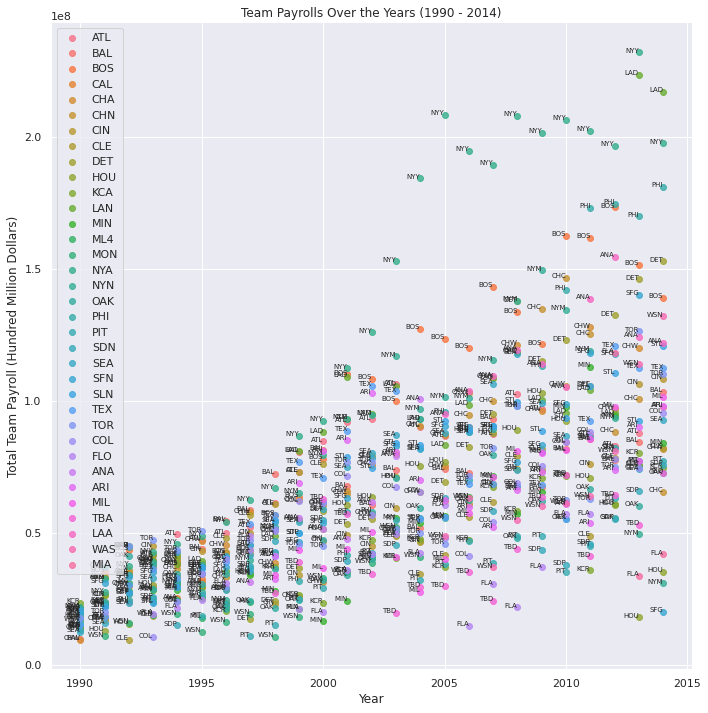

In [73]:
# Make the plot
sns.lmplot(height = 10, aspect = 1, x = "yearID", y = "total_payroll", data = df, fit_reg=False, hue='teamID', legend=False).set(
    title = "Team Payrolls Over the Years (1990 - 2014)"
)

# Annotate each point with the franchise ID
for idx in range(0,len(df)):
  plt.text(df['yearID'][idx], 
           df['total_payroll'][idx] + 0.2,
           df['franchID'][idx], 
           horizontalalignment='right', 
           ma = 'left',
           size = 'xx-small')
  
# Create legend matching colors to teams
plt.legend(loc='best')

# Label axes
plt.xlabel('Year')
plt.ylabel('Total Team Payroll (Hundred Million Dollars)')

plt.show()

### Question 1
What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.?

Ans: As you can see from the ploy, from 1990 to 2014, there seems to be a trend for team payrolls to increase per yer. We can analyze the mean of total team payrolls over time. In addition, the range of team payrolls per year has increased dramatically.

### Problem 3
Produce a scatterplot showing the increase in average total payroll across the league over time.

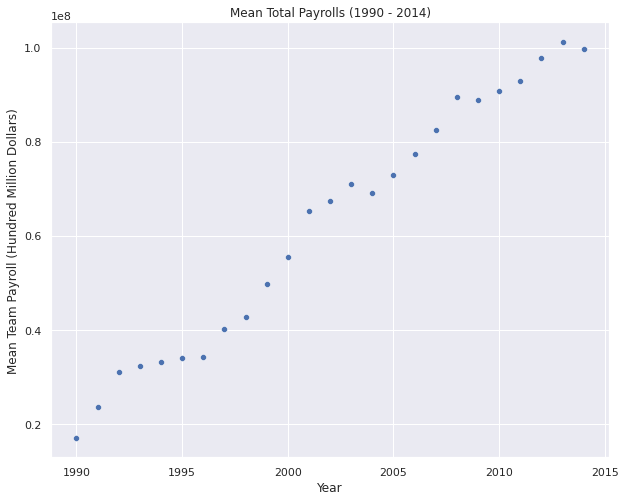

In [74]:
# Query from the team_salaries table to get the average total payroll across the league per yer from 1990
average_total_payroll_query = """SELECT yearID, avg(total_payroll) as average_total_payroll 
                FROM team_salaries
                WHERE yearID >= 1990
                GROUP BY yearID
"""
# Creating a new dataframe of average team payroll per year
average_total_payroll = pandas.read_sql(average_total_payroll_query, conn)


# Make the plot
sns.scatterplot(data=average_total_payroll, x="yearID", y="average_total_payroll").set(
    title = "Mean Total Payrolls (1990 - 2014)")
sns.set(rc={"figure.figsize":(10, 8)})

# Label axes
plt.xlabel('Year')
plt.ylabel('Mean Team Payroll (Hundred Million Dollars)')

plt.show()

### Problem 4
Discretize year into five time periods and make a scatterplot showing average team payroll (x axis) vs. average team winning percentage (y axis) for each of the five time periods with a regression line in each graph.

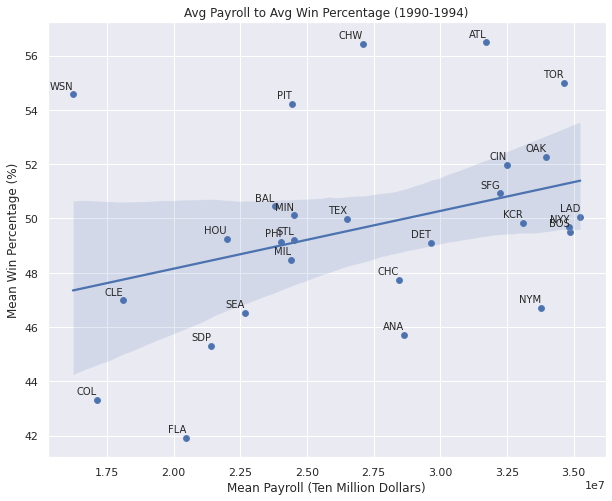

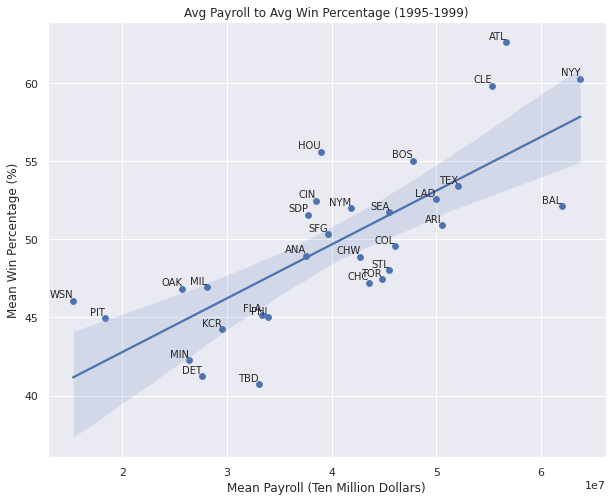

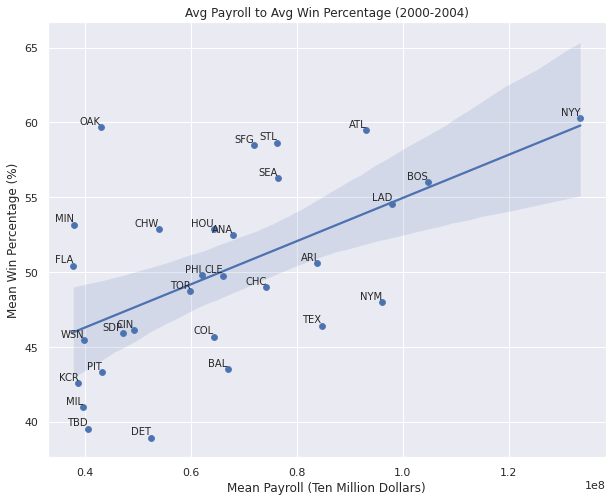

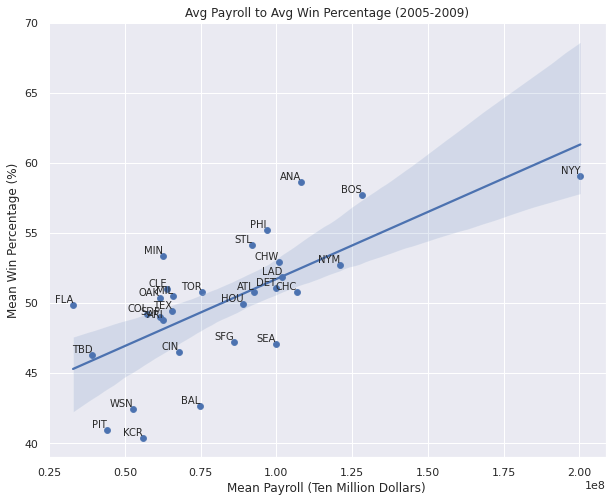

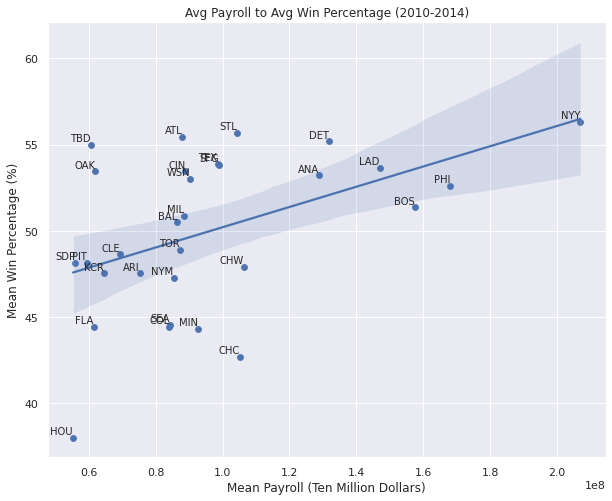

In [86]:
### Creating separate dataframes for each time period correlating
### each team's avg payroll to their avg winning percentage

## 1990 - 1994 ##
df_1990_1994 = df[ (df['yearID'] >= 1990) & (df['yearID'] <= 1994) ]
df_1990_1994 = df_1990_1994.to_sql('df_1990_1994', conn, if_exists='replace')
query_1990_1994 = """
                  SELECT  franchID,
                          avg(win_percentage) as avg_win_percentage,
                          avg(total_payroll) as avg_total_payroll
                  FROM df_1990_1994
                  GROUP BY franchID
"""
payroll_to_wins_1990_1994 = pandas.read_sql(query_1990_1994, conn)


## 1995 - 1999 ##
df_1995_1999 = df[ (df['yearID'] >= 1995) & (df['yearID'] <= 1999) ]
df_1995_1999 = df_1995_1999.to_sql('df_1995_1999', conn, if_exists='replace')
query_1995_1999 = """
                  SELECT  franchID,
                          avg(win_percentage) as avg_win_percentage,
                          avg(total_payroll) as avg_total_payroll
                  FROM df_1995_1999
                  GROUP BY franchID
"""
payroll_to_wins_1995_1999 = pandas.read_sql(query_1995_1999, conn)


## 2000 - 2004 ##
df_2000_2004 = df[ (df['yearID'] >= 2000) & (df['yearID'] <= 2004) ]
df_2000_2004 = df_2000_2004.to_sql('df_2000_2004', conn, if_exists='replace')
query_2000_2004 = """
                  SELECT  franchID,
                          avg(win_percentage) as avg_win_percentage,
                          avg(total_payroll) as avg_total_payroll
                  FROM df_2000_2004
                  GROUP BY franchID
"""
payroll_to_wins_2000_2004 = pandas.read_sql(query_2000_2004, conn)


## 2005 - 2009 ##
df_2005_2009 = df[ (df['yearID'] >= 2005) & (df['yearID'] <= 2009) ]
df_2005_2009 = df_2005_2009.to_sql('df_2005_2009', conn, if_exists='replace')
query_2005_2009 = """
                  SELECT  franchID,
                          avg(win_percentage) as avg_win_percentage,
                          avg(total_payroll) as avg_total_payroll
                  FROM df_2005_2009
                  GROUP BY franchID
"""
payroll_to_wins_2005_2009 = pandas.read_sql(query_2005_2009, conn)


## 2010 - 2014 ##
df_2010_2014 = df[ (df['yearID'] >= 2010) & (df['yearID'] <= 2014) ]
df_2010_2014 = df_2010_2014.to_sql('df_2010_2014', conn, if_exists='replace')
query_2010_2014 = """
                  SELECT  franchID,
                          avg(win_percentage) as avg_win_percentage,
                          avg(total_payroll) as avg_total_payroll
                  FROM df_2010_2014
                  GROUP BY franchID
"""
payroll_to_wins_2010_2014 = pandas.read_sql(query_2010_2014, conn)


### Plotting all five plots ###

time_periods = [1994, 1999, 2004, 2009, 2014]

# Determining which of the time period dataframes to use
df_to_plot = df
for tp in time_periods:
  if tp >= 1990 and tp <= 1994 :
    df_to_plot = payroll_to_wins_1990_1994
  elif tp >= 1995 and tp <= 1999 :
    df_to_plot = payroll_to_wins_1995_1999
  elif tp >= 2000 and tp <= 2004 :
    df_to_plot = payroll_to_wins_2000_2004
  elif tp >= 2005 and tp <= 2009 :
    df_to_plot = payroll_to_wins_2005_2009
  elif tp >= 2010 and tp <= 2014 :
    df_to_plot = payroll_to_wins_2010_2014
  
  # Make the plot
  sns.scatterplot(data = df_to_plot, x = "avg_total_payroll", y = "avg_win_percentage").set(
      title = "Avg Payroll to Avg Win Percentage (" + str((tp-4)) + "-" + str(tp) + ")" 
  )
  sns.set(rc={"figure.figsize":(10, 8)})

  # Annotate each point with the franchise ID
  for idx in range(0,len(df_to_plot)) :
    plt.text(df_to_plot['avg_total_payroll'][idx],
             df_to_plot['avg_win_percentage'][idx] + 0.2,
             df_to_plot['franchID'][idx],
             horizontalalignment = 'right',
             ma = 'left',
             size = 'small')
  
  # Plot the regression line
  sns.regplot(x = df_to_plot['avg_total_payroll'],
              y = df_to_plot['avg_win_percentage'])
  
  # Label axes
  plt.xlabel('Mean Payroll (Ten Million Dollars)')
  plt.ylabel('Mean Win Percentage (%)')
  
  plt.show()

### Question 2
What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

Ans: Over these time periods, there is a general trend that if a team spends more money, it leads to a higher winning percentage. 
In nearly every graph, the New York Yankees (NYA) are either at or near the top in average payroll and, accordingly, are at or the near top in average winning percentage.
Meanwhile, the Oakland A's (OAK) are a great example of a team with high spending efficiency in that they had a high winning percentage despite having one of the lowest team payrolls. From 1995 - 1999, they had a low team salary and didn't win many games. However, from 2000 - 2004, they had a high winning percentage despite having one of of the lowest team payrolls. They always had a positive spending efficiency, but it was maximized from 2000 - 2004.


# Part 3

### Problem 5
Create a variable that standardizes payroll conditioned on year.
######Standardized payroll(team, year) = (Payroll(team, year) - Avg payroll(year)) / standard deviation of payroll(year)

In [90]:
standardized_payroll = []
new_year_string = 0

# Iterating through the dataframe for the needed data for each team
for idx, row in df.iterrows():
  year_string = df['yearID'][idx]
  if year_string != new_year_string :
    new_year_string = year_string

    # All the average payrolls in the league in a given year
    total_of_avg_payrolls = df.query('yearID == @year_string')['total_payroll'].reset_index(drop=True)

    # The average total payroll for the league in a given year
    avg = average_total_payroll.loc[average_total_payroll['yearID'] == df['yearID'][idx], 
        'average_total_payroll'].iloc[0]
    
    # Standard deviation of payrolls in a given year
    std_dev = total_of_avg_payrolls.std()

  # Team payroll in a given year
  team_payroll = df['total_payroll'][idx]
  
  num = team_payroll - avg
  denom = std_dev
  standardized_payroll.append(num/denom)

df['standardized_payroll'] = standardized_payroll
df

,yearID,teamID,franchID,W,G,total_payroll,win_percentage,standardized_payroll,exp_win_percentage,efficiency
0,1990,ATL,ATL,65,162,14555501.0,40.123457,-0.667275,48.331811,-8.208354
1,1990,BAL,BAL,76,161,9680084.0,47.204969,-1.959861,45.100348,2.104621
2,1990,BOS,BOS,88,162,20558333.0,54.320988,0.924213,52.310533,2.010454
3,1990,CAL,ANA,80,162,21720000.0,49.382716,1.232198,53.080495,-3.697779
4,1990,CHA,CHW,94,162,9491500.0,58.024691,-2.009859,44.975353,13.049338
...,...,...,...,...,...,...,...,...,...,...
723,2014,SLN,STL,90,162,120693000.0,55.555556,0.458003,51.145009,4.410547
724,2014,TBA,TBD,77,162,72689100.0,47.530864,-0.592294,48.519265,-0.988401
725,2014,TEX,TEX,67,162,112255059.0,41.358025,0.273386,50.683466,-9.325441
726,2014,TOR,TOR,83,162,109920100.0,51.234568,0.222299,50.555747,0.678821


### Problem 6
Discretize year into five time periods and make a scatterplot showing average standardized payroll (x axis) vs. average team winning percentage (y axis) for each of the five time periods with a regression line in each graph.

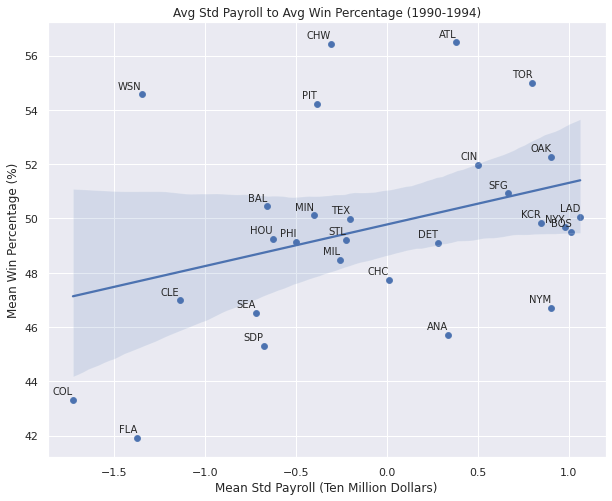

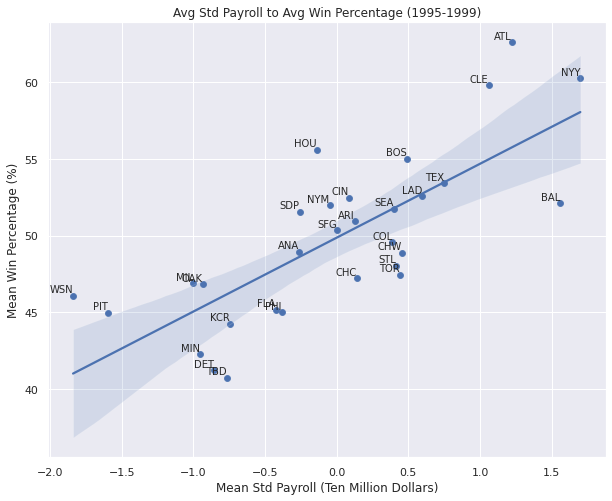

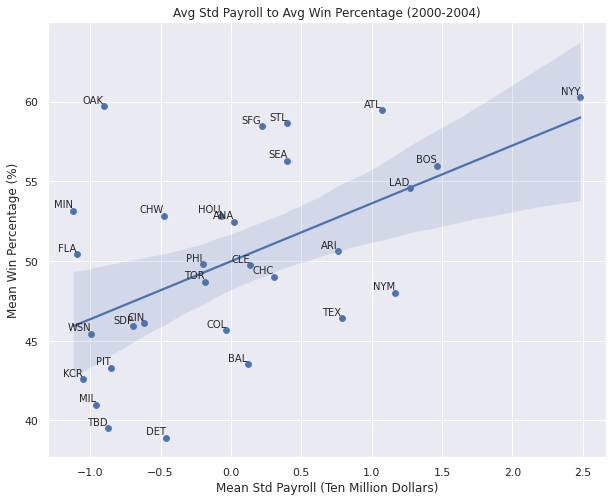

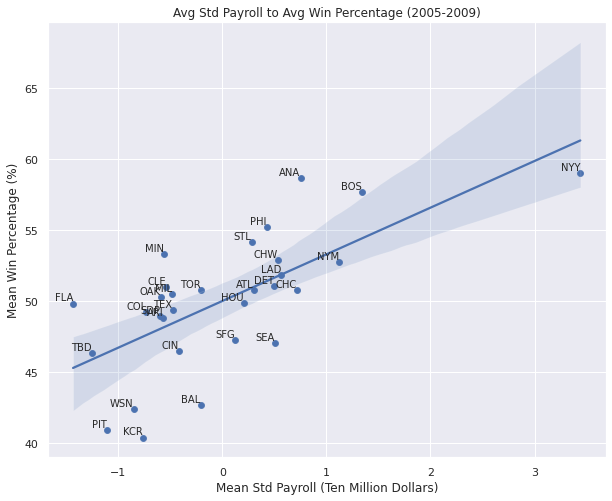

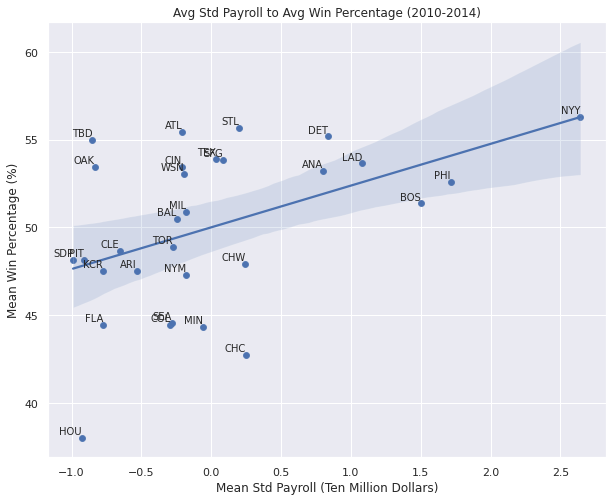

In [92]:
### Creating separate dataframes for each time period correlating 
### each team's avg standardized payroll to their avg winning percentage

## 1990 - 1994 ##
df_1990_1994 = df[ (df['yearID'] >= 1990) & (df['yearID'] <= 1994) ]
df_1990_1994 = df_1990_1994.to_sql('df_1990_1994', conn, if_exists='replace')
query_1990_1994 = """
                  SELECT  franchID,
                          avg(win_percentage) as avg_win_percentage,
                          avg(standardized_payroll) as avg_std_payroll
                  FROM df_1990_1994
                  GROUP BY franchID
"""
payroll_to_wins_1990_1994 = pandas.read_sql(query_1990_1994, conn)


## 1995 - 1999 ##
df_1995_1999 = df[ (df['yearID'] >= 1995) & (df['yearID'] <= 1999) ]
df_1995_1999 = df_1995_1999.to_sql('df_1995_1999', conn, if_exists='replace')
query_1995_1999 = """
                  SELECT  franchID,
                          avg(win_percentage) as avg_win_percentage,
                          avg(standardized_payroll) as avg_std_payroll
                  FROM df_1995_1999
                  GROUP BY franchID
"""
payroll_to_wins_1995_1999 = pandas.read_sql(query_1995_1999, conn)


## 2000 - 2004 ##
df_2000_2004 = df[ (df['yearID'] >= 2000) & (df['yearID'] <= 2004) ]
df_2000_2004 = df_2000_2004.to_sql('df_2000_2004', conn, if_exists='replace')
query_2000_2004 = """
                  SELECT  franchID,
                          avg(win_percentage) as avg_win_percentage,
                          avg(standardized_payroll) as avg_std_payroll
                  FROM df_2000_2004
                  GROUP BY franchID
"""
payroll_to_wins_2000_2004 = pandas.read_sql(query_2000_2004, conn)


## 2005 - 2009 ##
df_2005_2009 = df[ (df['yearID'] >= 2005) & (df['yearID'] <= 2009) ]
df_2005_2009 = df_2005_2009.to_sql('df_2005_2009', conn, if_exists='replace')
query_2005_2009 = """
                  SELECT  franchID,
                          avg(win_percentage) as avg_win_percentage,
                          avg(standardized_payroll) as avg_std_payroll
                  FROM df_2005_2009
                  GROUP BY franchID
"""
payroll_to_wins_2005_2009 = pandas.read_sql(query_2005_2009, conn)


## 2010 - 2014 ##
df_2010_2014 = df[ (df['yearID'] >= 2010) & (df['yearID'] <= 2014) ]
df_2010_2014 = df_2010_2014.to_sql('df_2010_2014', conn, if_exists='replace')
query_2010_2014 = """
                  SELECT  franchID,
                          avg(win_percentage) as avg_win_percentage,
                          avg(standardized_payroll) as avg_std_payroll
                  FROM df_2010_2014
                  GROUP BY franchID
"""
payroll_to_wins_2010_2014 = pandas.read_sql(query_2010_2014, conn)



### Plotting all five plots ###

time_periods = [1994, 1999, 2004, 2009, 2014]

# Determining which of the time period dataframes to use
df_to_plot = df
for tp in time_periods:
  if tp >= 1990 and tp <= 1994 :
    df_to_plot = payroll_to_wins_1990_1994
  elif tp >= 1995 and tp <= 1999 :
    df_to_plot = payroll_to_wins_1995_1999
  elif tp >= 2000 and tp <= 2004 :
    df_to_plot = payroll_to_wins_2000_2004
  elif tp >= 2005 and tp <= 2009 :
    df_to_plot = payroll_to_wins_2005_2009
  elif tp >= 2010 and tp <= 2014 :
    df_to_plot = payroll_to_wins_2010_2014
  
  # Make the plot
  sns.scatterplot(data = df_to_plot, x = "avg_std_payroll", y = "avg_win_percentage").set(
      title = "Avg Std Payroll to Avg Win Percentage (" + str((tp-4)) + "-" + str(tp) + ")" 
  )
  sns.set(rc={"figure.figsize":(10, 8)})

  # Annotate each point with the franchise ID
  for idx in range(0,len(df_to_plot)) :
    plt.text(df_to_plot['avg_std_payroll'][idx],
             df_to_plot['avg_win_percentage'][idx] + 0.2,
             df_to_plot['franchID'][idx],
             horizontalalignment = 'right',
             ma = 'left',
             size = 'small')
  
  # Plot the regression line
  sns.regplot(x = df_to_plot['avg_std_payroll'],
              y = df_to_plot['avg_win_percentage'])
  
  # Label axes
  plt.xlabel('Mean Std Payroll (Ten Million Dollars)')
  plt.ylabel('Mean Win Percentage (%)')
  
  plt.show()

### Question 3
Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable.

Ans: The graphs from problems 4 and 6 show the same increasing trend between spending money and winning games.
The graphs from problem 4 have a positive x axis making it easy to see the actual average payrolls but difficult to compare between time periods since the average payroll per team increases over team.
The graphs from problem 6 help us compare correlation of standardized payroll to winning percentage because we can observe how far a team's payroll is to the average and judge their efficiency more fairly through the years.
If a team has a positive standardized payroll, it means they are spending more than the average team and vice versa.

### Problem 7
Make a single scatter plot of standardized payroll (x-axis) vs. winning percentage (y-axis). Add a regression line to highlight the relationship.

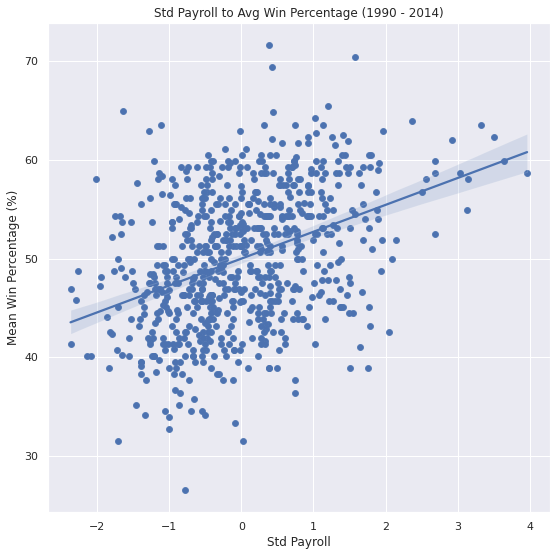

In [95]:
# Make the plot
fig, ax = plt.subplots(figsize = (9, 9))
sns.scatterplot(data=df, x="standardized_payroll", y="win_percentage").set(
    title = "Std Payroll to Avg Win Percentage (1990 - 2014)"
)
sns.set(rc={"figure.figsize":(10, 8)})

# Add the regression line
sns.regplot(x=df['standardized_payroll'],
           y=df['win_percentage'],)

# Label the axes
plt.xlabel('Std Payroll')
plt.ylabel('Mean Win Percentage (%)')

plt.show()


### Problem 8
Create a new variable to compute each team's spending efficiency.
###### expected win pct(team, year) = 50 + 2.5 * standardized payroll(team, year)
###### efficiency(team, year) = win pct(team, year) - expected win pct(team, year)
Make a line plot with year (x-axis) and efficiency (y-axis) with chosen teams, Oakland, New York Yankees, Boston, Atlanta, and Tampa Bay



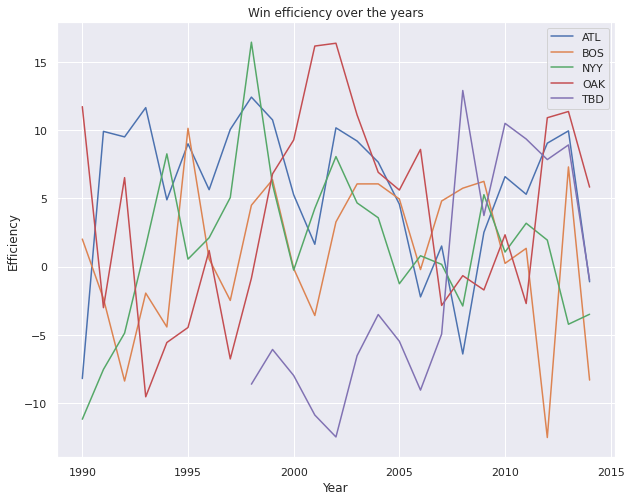

In [96]:
# Creating a new column with expected win percentage and efficiency for each team / year
df['exp_win_percentage'] = df['standardized_payroll'] * 2.5 + 50
df['efficiency'] = df['win_percentage'] - df['exp_win_percentage']

teams = ['OAK', 'BOS', 'NYY', 'ATL', 'TBD']

# Extracting all the rows containing each each chosen franchise into a new dataframe
df_teams = df.loc[df['franchID'].isin(teams)]

# Make the plot
sns.lineplot(data = df_teams, x = "yearID", y = "efficiency", hue = "franchID").set(
    title = "Win efficiency over the years"
)

# Legend associating color with franchise
plt.legend(loc='best')

# Label axes
plt.xlabel('Year')
plt.ylabel('Efficiency')

plt.show()

### Question 4
What can you learn from this plot compared to the set of plots you looked at in Question 2 and 3? How good was Oakland's efficiency during the Moneyball period?

Ans: From this plot, we can observe each team's winning efficiency per year. The plots in questions 2 and 3 tell us which teams won a lot, but what the plot in question 4 tells us is how much each team won compared to their expected win percentage for each year.

The expected win percentage is calculated based on a team's payroll.



We see that the Oakland A's winning efficiency makes sense based on the results found in questions 2 and 3. 

From 2000 to 2004, the Moneyball period, Oakland's winning efficieny ranged between 10 and 17, meaning they won 10 to 17 more games than expected based on their yearly team salary, more games than any other team illustrated.